In [26]:
import pandas as pd
import pybedtools
from ALLCools.mcds import MCDS
import glob
import joblib
import dask

In [2]:
gene_meta_path = '/data/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
chrom_to_remove = ['chrM','chrY']

# change this to the path to your filtered metadata
metadata_path = '../221027_AMB_metadata.csv'

# change this to the paths to your MCDS files
aging_mcds_path_list = glob.glob("/data/aging/dataset/aging/mcds/*.mcds")
cemba_mcds_path_list = glob.glob("/data/aging/dataset/cemba/mcds/*.mcds")
mcds_path = aging_mcds_path_list + cemba_mcds_path_list
obs_dim = 'cell'
var_dim = 'geneslop2k'

min_cov = 5

## load metadata

In [3]:
gene_meta = pd.read_csv(gene_meta_path, index_col='gene_id', sep='\t')

In [4]:
metadata = pd.read_csv(metadata_path, index_col=0)
total_cells = metadata.shape[0]
print(f'Metadata of {total_cells} cells')

Metadata of 132747 cells


## filter genes by overlap and chrs

In [5]:
genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])

mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

In [6]:
# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

40342 features remained


## filter genes by cell mean coverage

In [7]:
cemba_mcds = MCDS.open(cemba_mcds_path_list, 
                var_dim=var_dim,
                 use_obs=metadata.index).sel({var_dim: use_features})

aging_mcds = MCDS.open(aging_mcds_path_list, 
                 var_dim=var_dim,
                 use_obs=metadata.index).sel({var_dim: use_features})

Feature geneslop2k mean cov across cells added in MCDS.coords['geneslop2k_cov_mean'].


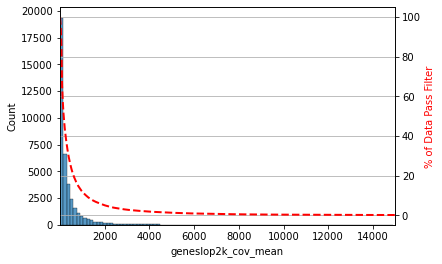

In [11]:
cemba_mcds.add_feature_cov_mean(var_dim=var_dim)

Feature geneslop2k mean cov across cells added in MCDS.coords['geneslop2k_cov_mean'].


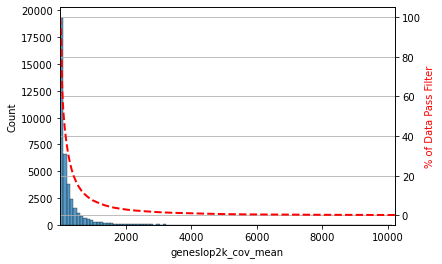

In [12]:
aging_mcds.add_feature_cov_mean(var_dim=var_dim)

In [20]:
cemba_mcds = cemba_mcds.filter_feature_by_cov_mean(min_cov=min_cov)

Before cov mean filter: 40342 geneslop2k
 After cov mean filter: 39794 geneslop2k 98.6%


In [21]:
aging_mcds = aging_mcds.filter_feature_by_cov_mean(min_cov=min_cov)

Before cov mean filter: 40342 geneslop2k
 After cov mean filter: 39683 geneslop2k 98.4%


In [22]:
use_features = cemba_mcds.get_index(var_dim).intersection(aging_mcds.get_index(var_dim))

In [23]:
joblib.dump(use_features, 'use_features_list')

['use_features_list']

## calculate and save gene mC fraction

In [27]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # still use all the cells to load MCDS
    total_mcds = MCDS.open(aging_mcds_path_list+cemba_mcds_path_list,
                           obs_dim=obs_dim,
                           use_obs=metadata.index).sel({var_dim: use_features})

In [30]:
total_mcds.add_mc_frac(normalize_per_cell=True, var_dim = var_dim, clip_norm_value=10)

In [32]:
# only keep fraction for saving
mcds = total_mcds[['geneslop2k_da_frac']]
mcds['geneslop2k_da_frac'] = mcds['geneslop2k_da_frac'].astype('float32')

In [33]:
mcds.write_dataset('geneslop2k_frac.mcds', var_dims=['geneslop2k'])

Saving geneslop2k
Saving chunk 0: 0 - 10000
Saving chunk 1: 10000 - 20000
Saving chunk 2: 20000 - 30000
Saving chunk 3: 30000 - 40000
Saving chunk 4: 40000 - 50000
Saving chunk 5: 50000 - 60000
Saving chunk 6: 60000 - 70000
Saving chunk 7: 70000 - 80000
Saving chunk 8: 80000 - 90000
Saving chunk 9: 90000 - 100000
Saving chunk 10: 100000 - 110000
Saving chunk 11: 110000 - 120000
Saving chunk 12: 120000 - 130000
Saving chunk 13: 130000 - 132747


In [34]:
mcds

<xarray.MCDS>
Dimensions:             (cell: 132747, geneslop2k: 39681, mc_type: 2)
Coordinates:
  * mc_type             (mc_type) <U3 'CGN' 'CHN'
  * geneslop2k          (geneslop2k) <U21 'ENSMUSG00000102693.1' ... 'ENSMUSG...
    geneslop2k_chrom    (geneslop2k) <U5 'chr1' 'chr1' 'chr1' ... 'chrX' 'chrX'
    geneslop2k_start    (geneslop2k) int32 3071252 3100015 ... 170670643
    geneslop2k_end      (geneslop2k) int32 3076321 3104124 ... 170680053
  * cell                (cell) <U42 'AMB_200218_9mo_8E_9H_8J_9J_2_P1-3-B24-P5...
    strand_type         <U4 'both'
Data variables:
    geneslop2k_da_frac  (cell, geneslop2k, mc_type) float32 dask.array<chunksize=(2304, 39681, 2), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  null

In [35]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv('GeneMetadata.csv.gz')